##clean data
##figure out period, phase, and amplitude of the star (sin wave)
##import starry, try to fit light curve with a rotating star with spots (starry tutorials)
https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
https://docs.lightkurve.org/
https://exofop.ipac.caltech.edu/tess/target.php?id=197598732
https://tess.mit.edu/toi-releases/toi-release-general/

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import lightkurve as lk
import corner
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import pip as pip
import os
import emcee
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from lightkurve import search_targetpixelfile
from astropy.io import fits
import starry

In [4]:
pixelfile = lk.search_targetpixelfile("tic197598732").download(quality_bitmask='hardest')
pixelfile.flux.shape
lightcurvetemp = pixelfile.to_lightcurve(aperture_mask='all');
exoplanettemp = lightcurvetemp.flatten().fold(period=0.838)

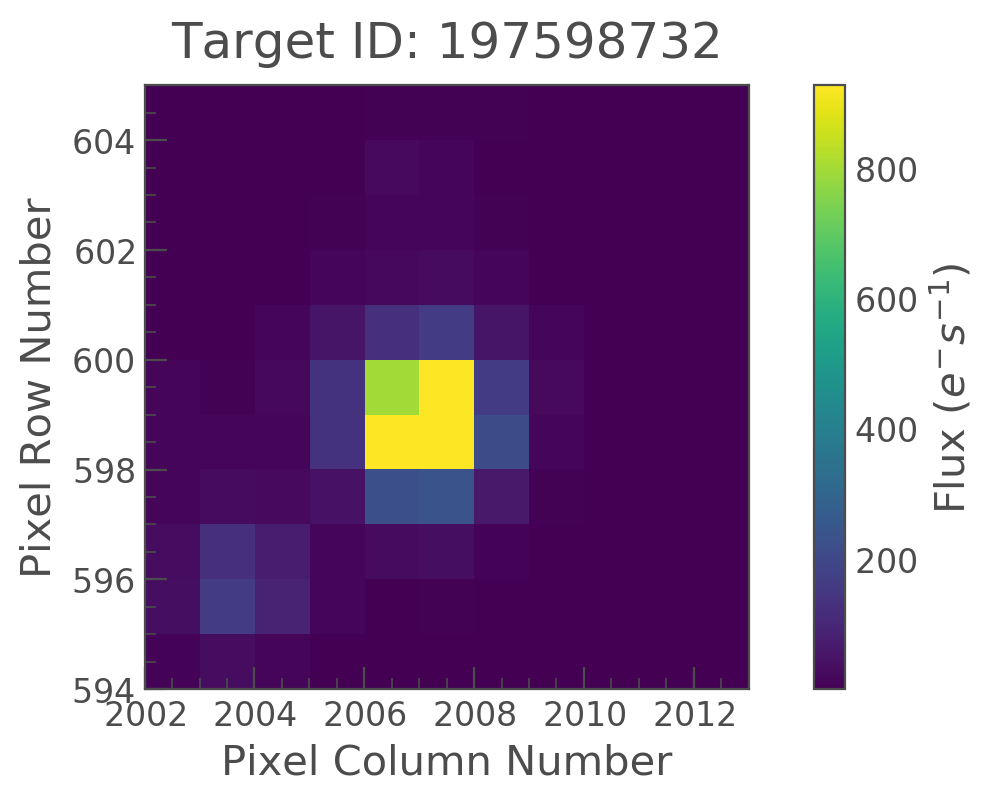

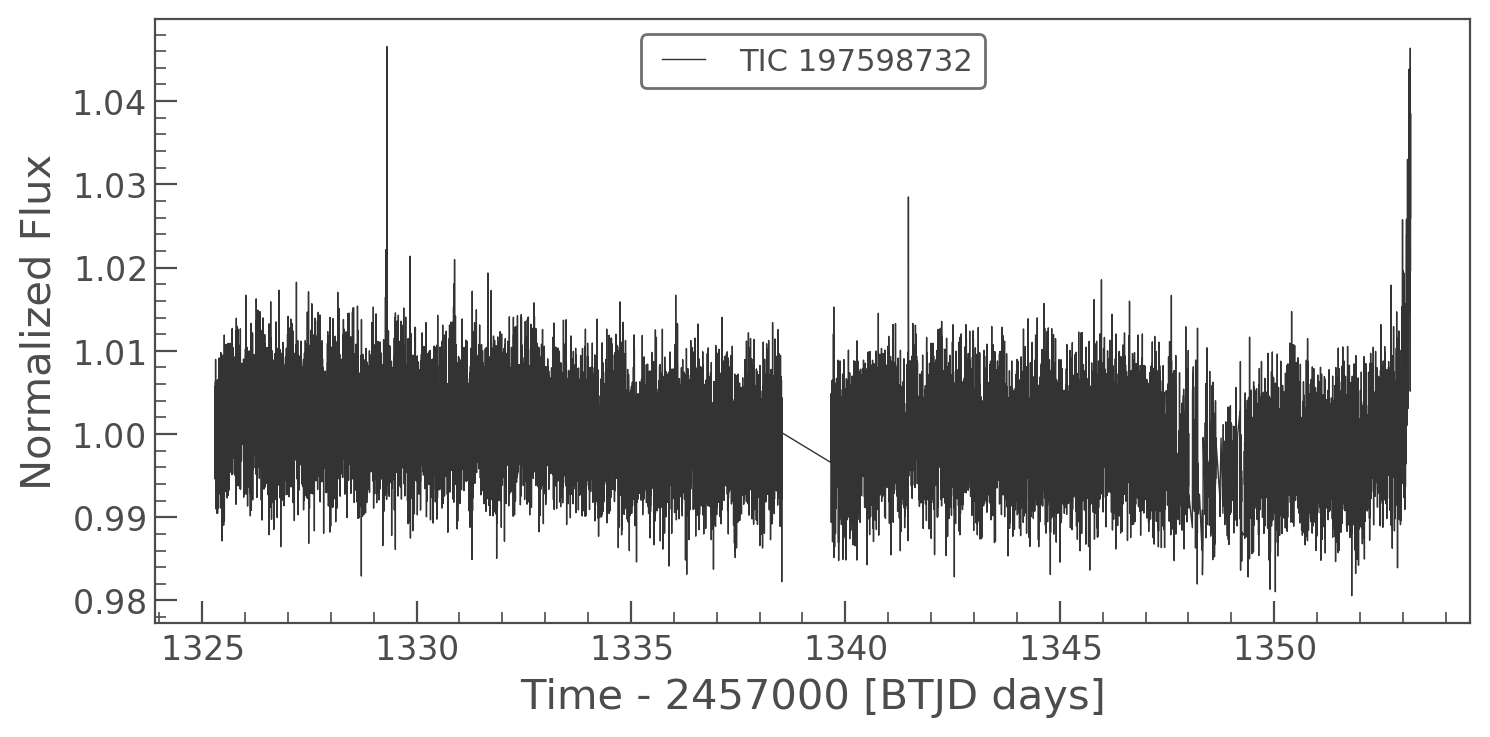

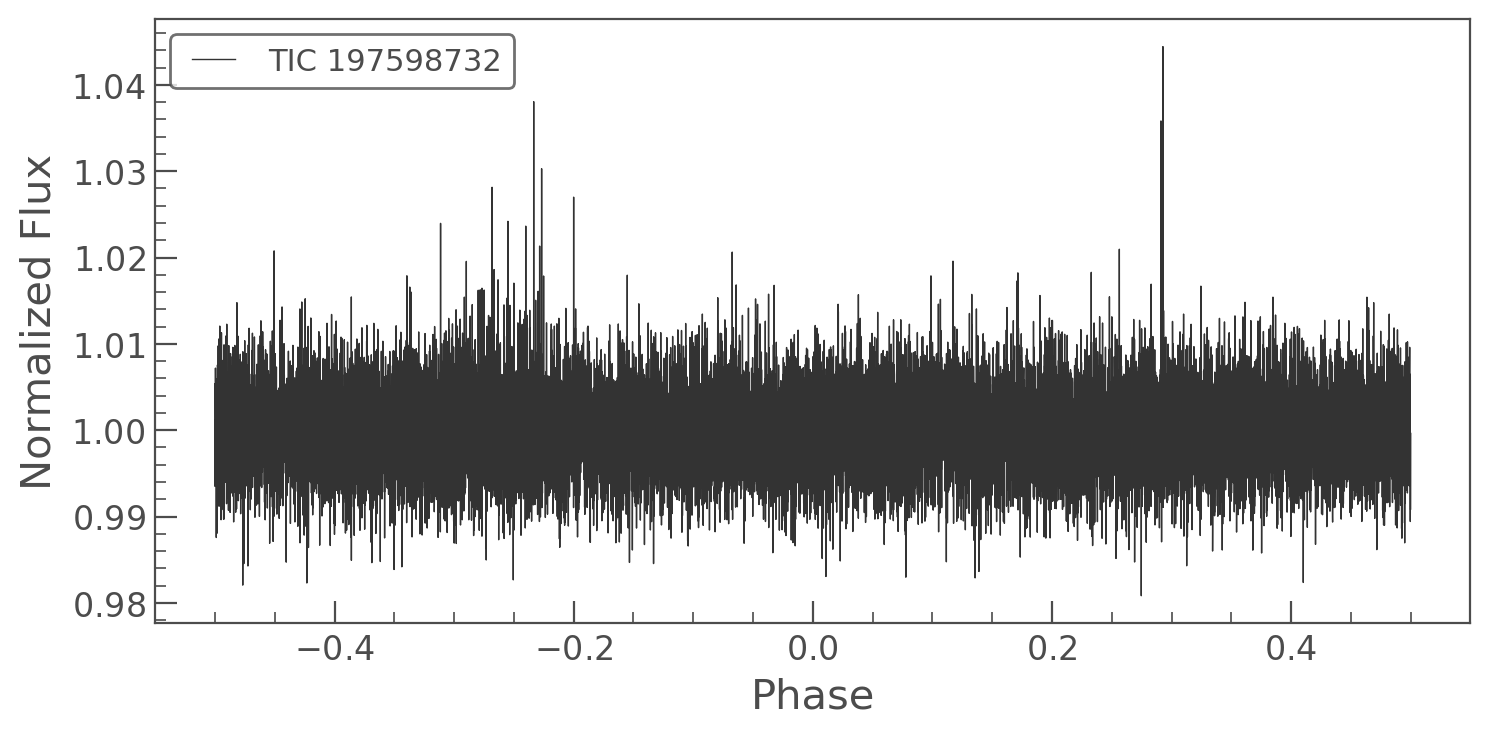

In [5]:
pixelfile.plot(frame=1)
lightcurvetemp.plot()
exoplanettemp.plot()

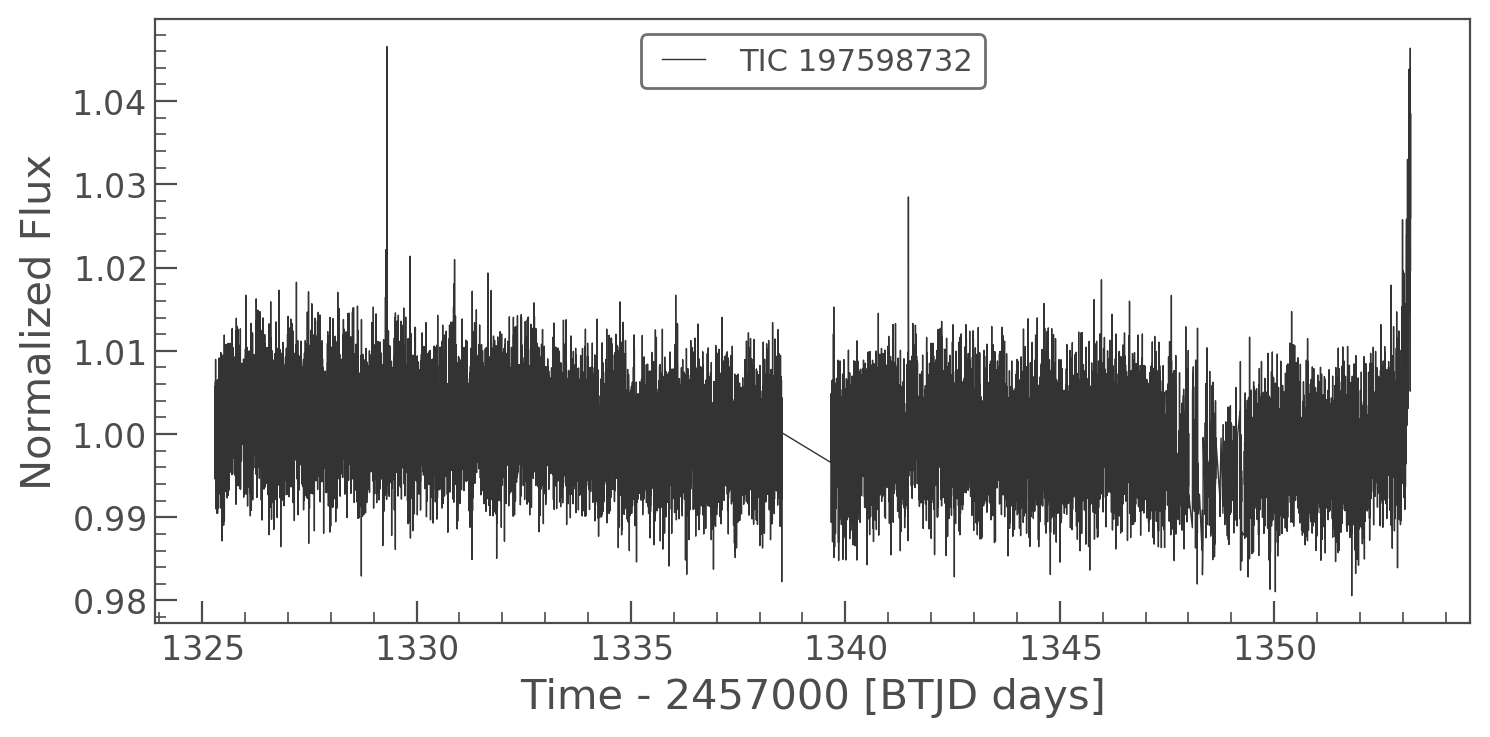

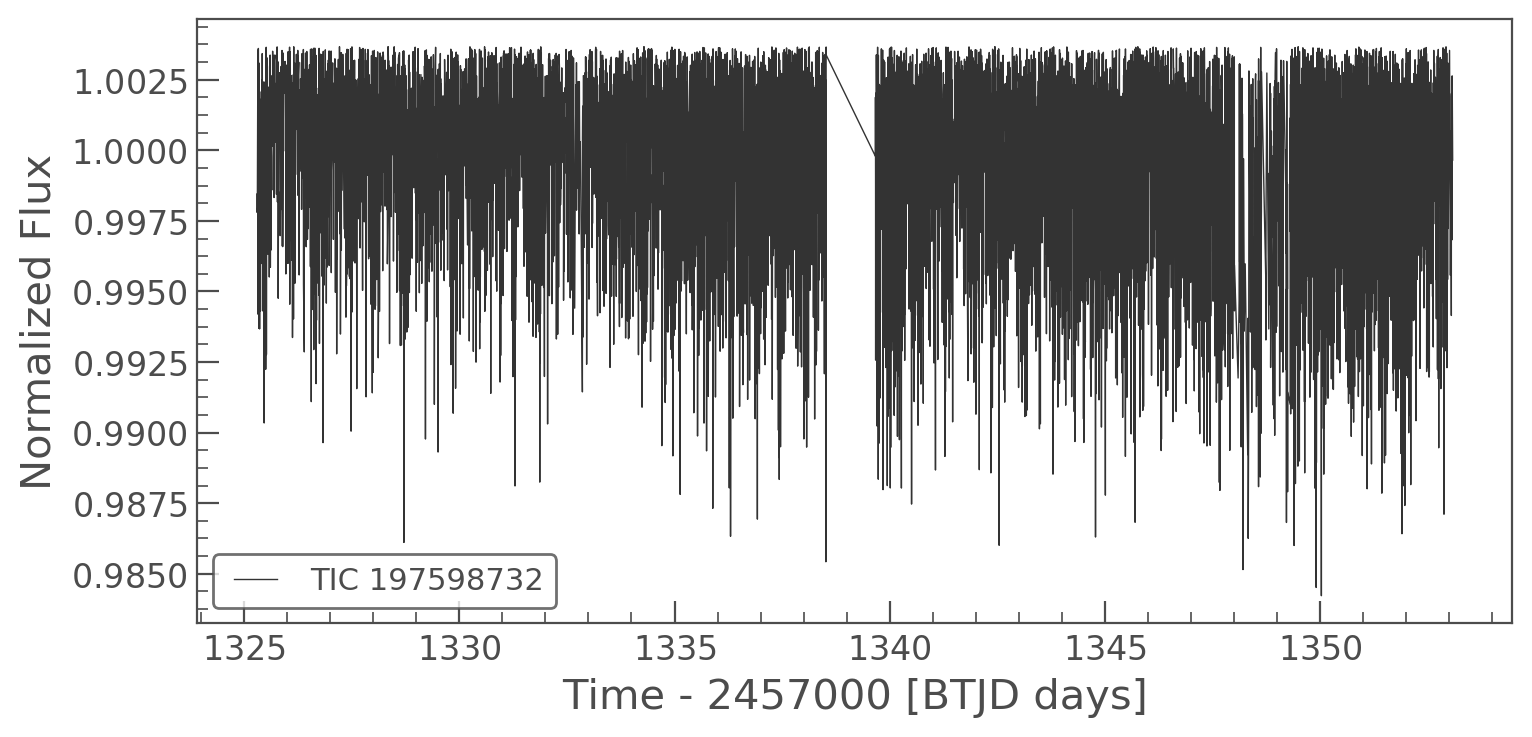

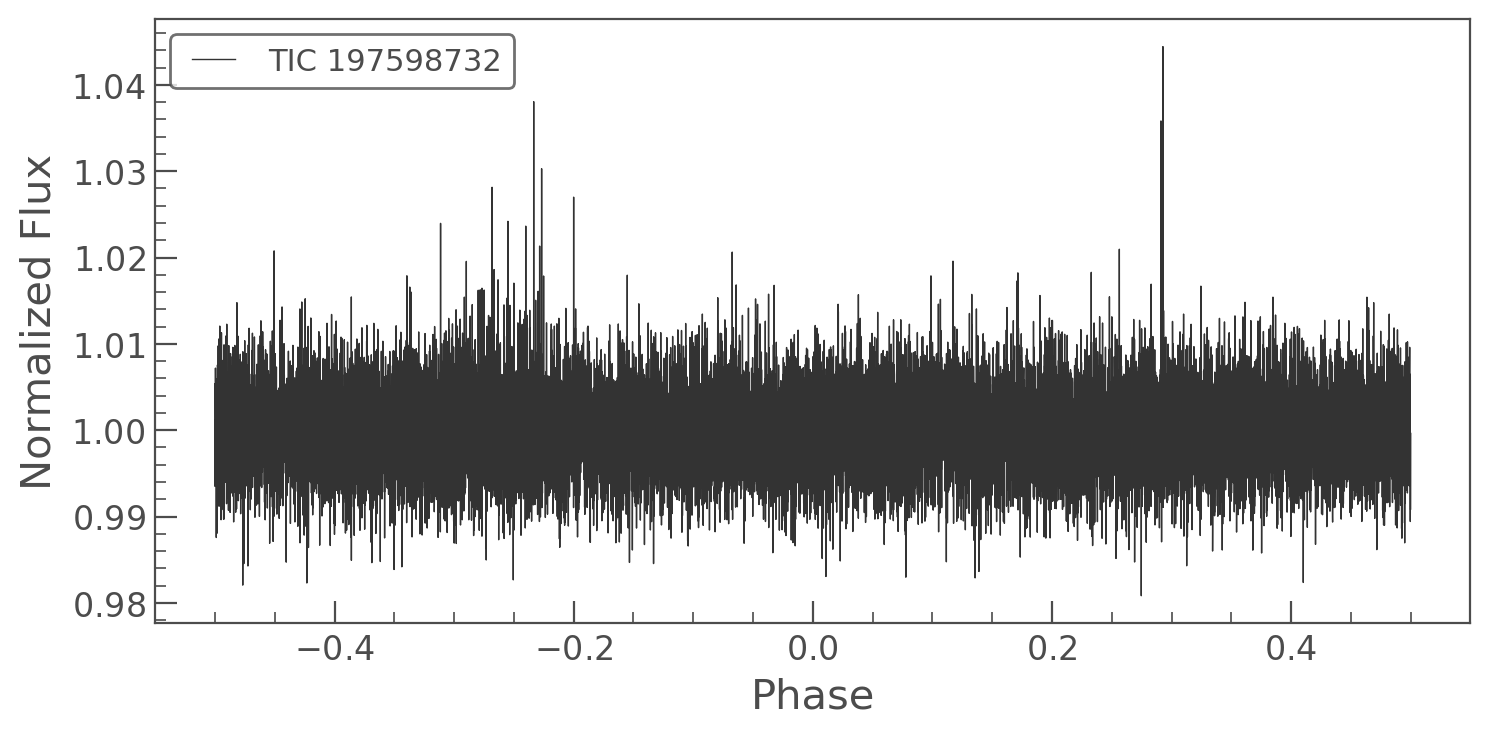

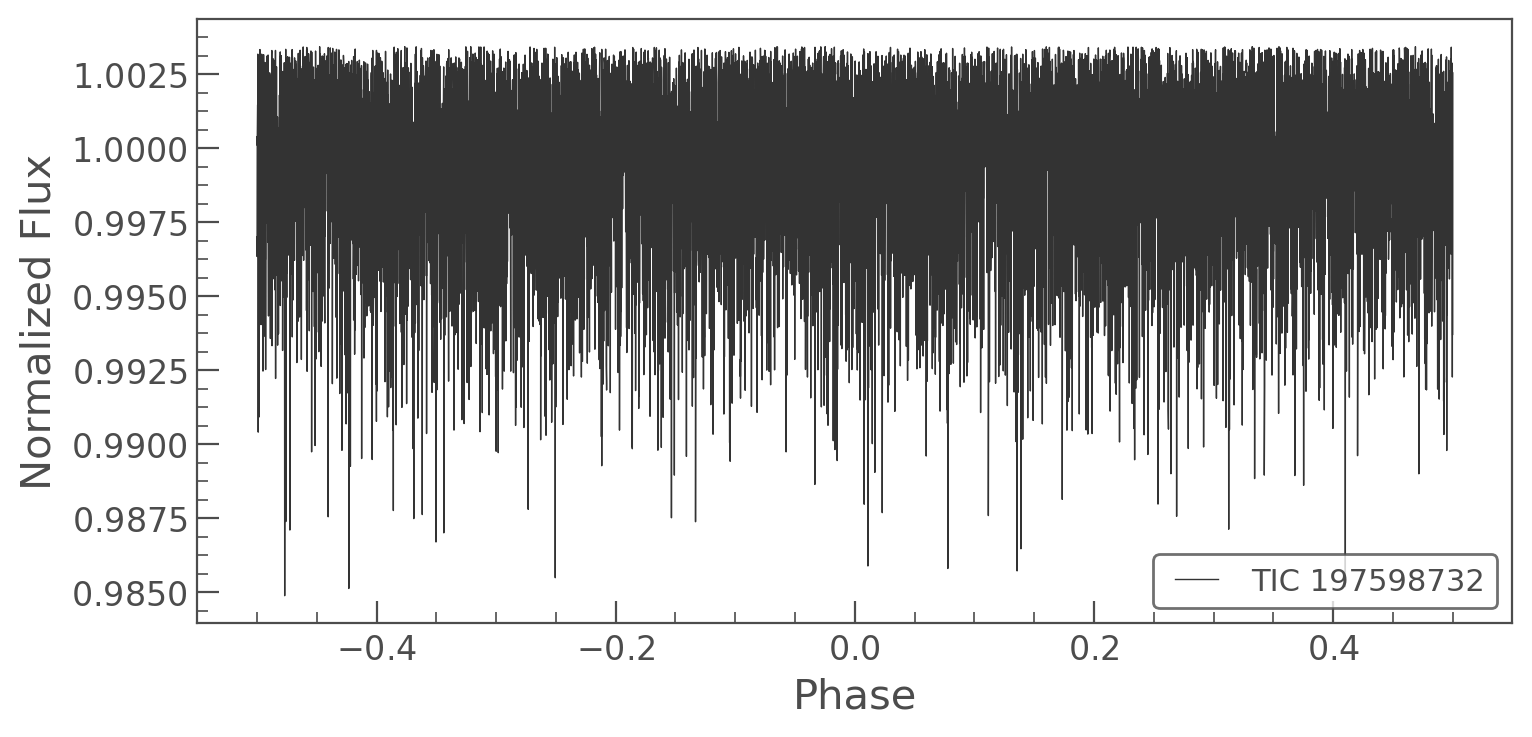

In [6]:
lightcurvetemp.plot()
lightcurve = lightcurvetemp.remove_outliers(sigma_upper = 1)
hdu = lightcurve.to_fits(path='lightcurve.fits', overwrite=True)
lightcurve.plot()
exoplanettemp.plot()
exoplanet = exoplanettemp.remove_outliers(sigma_upper = 1)
hdu = exoplanet.to_fits(path='exoplnaet.fits', overwrite=True)
exoplanet.plot()

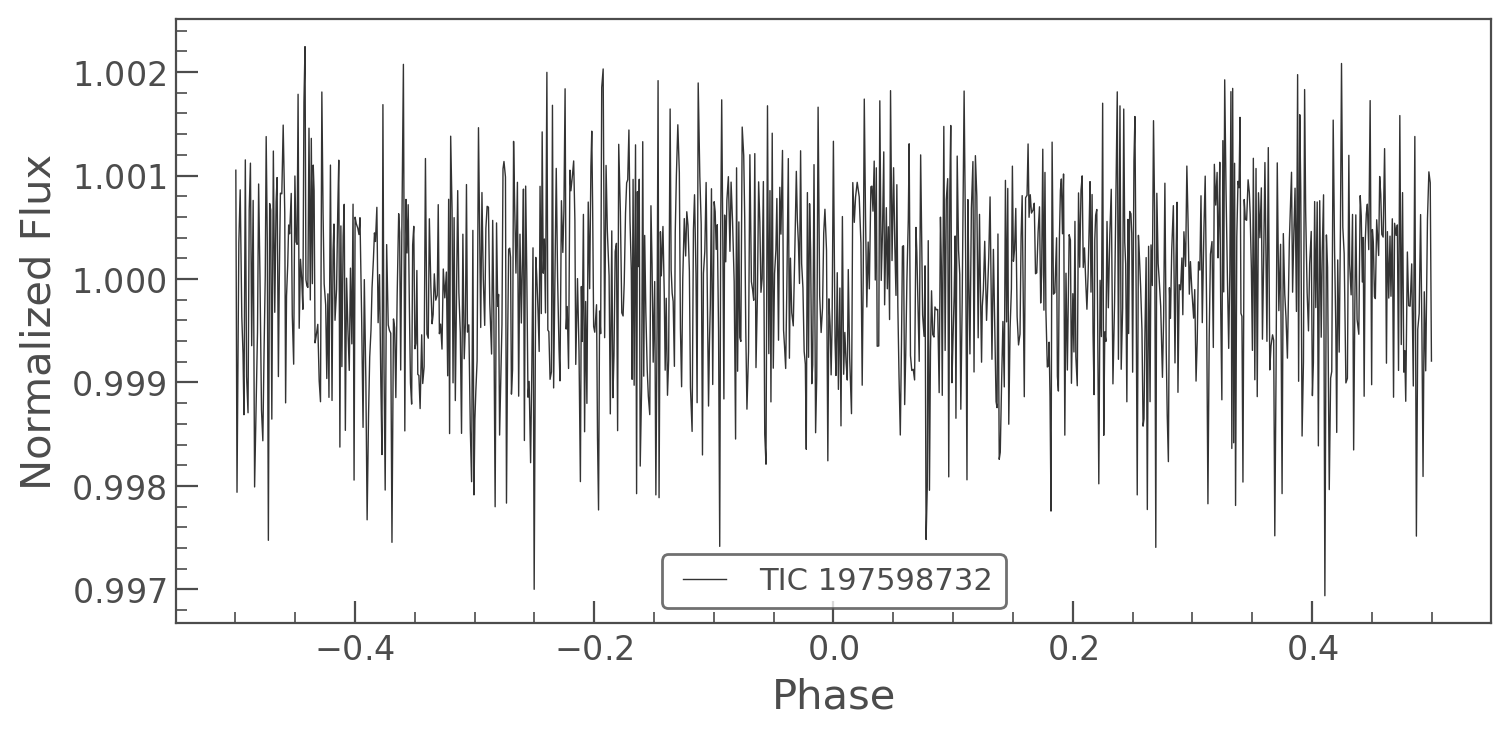

In [7]:
exoplanet2 = exoplanet.bin(binsize=10)
hdu = exoplanet2.to_fits(path='exoplanet2.fits', overwrite=True)
exoplanet2.plot();

In [8]:
#Trying to find amplitude, phase, period with exoplanet2.fits

In [9]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [10]:
if not os.path.exists("data"):
    os.mkdir("data")
    
truths = {
    "period": 5,
    "amplitude": 0.05,
    "phase": 2.825,
    "error": 0.04,
}

# Generate the light curve
time = np.arange(0, 27, 1. / 24. / 60.)
truths["flux"] = np.sin(2 * np.pi * time / truths["period"] + truths["phase"])
truths["flux"] *= truths["amplitude"]

# Add noise
np.random.seed(11)
err = np.ones_like(truths["flux"]) * truths["error"]
flux = np.array(truths["flux"])
flux += np.random.randn(len(time)) * err

# Save
X = np.hstack((time.reshape(-1, 1), 
               flux.reshape(-1, 1), 
               err.reshape(-1, 1)))
np.savetxt("exoplanet2.fits", X)

time, flux, err = np.loadtxt("exoplanet2.fits").T
plt.plot(time, flux, 'k.', ms=2, alpha=0.4, color = 'purple')
plt.xlabel("Time [days]")
plt.ylabel("Flux");

In [11]:
def model(period, phase, amplitude):
    return amplitude * np.sin(2 * np.pi / period * time + phase)
def lnlike(params):
    period, phase, amplitude = params
    chisq = np.sum((model(period, phase, amplitude) - flux) ** 2)
    return -0.5 * chisq

In [12]:
def lnprior_period(period):
    if period < 0:
        return -np.inf
    elif period > 10:
        return -np.inf
    else:
        return 0

def lnprior_amplitude(amplitude):
    if amplitude < 0:
        return -np.inf
    elif amplitude > 1:
        return -np.inf
    else:
        return 0

def lnprior_phase(phase):
    if phase < 0:
        return -np.inf
    elif phase > 2 * np.pi:
        return -np.inf
    else:
        return 0

In [13]:
def lnprior(params):
    period, phase, amplitude = params
    return lnprior_period(period) + lnprior_amplitude(amplitude) + lnprior_phase(phase) 
def lnprob(params):
    return lnprior(params) + lnlike(params)

#number of effective samples = (number of total) / (autocorelation of time)
#mcmc will do it for you .acor - like an extension of a period to something that is not periodic

In [14]:
nwalkers = 50
ndim = 3
mysamples = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
initial_pos = []
for i in range(nwalkers):
    period = np.random.uniform(0, 10)
    phase = np.random.uniform(0, 2 * np.pi)
    amplitude = np.random.uniform(0, 1)
    initial_pos.append([period, phase, amplitude])
mysamples.run_mcmc(initial_pos, 1000);
mysamples.chain.shape

(50, 1000, 3)

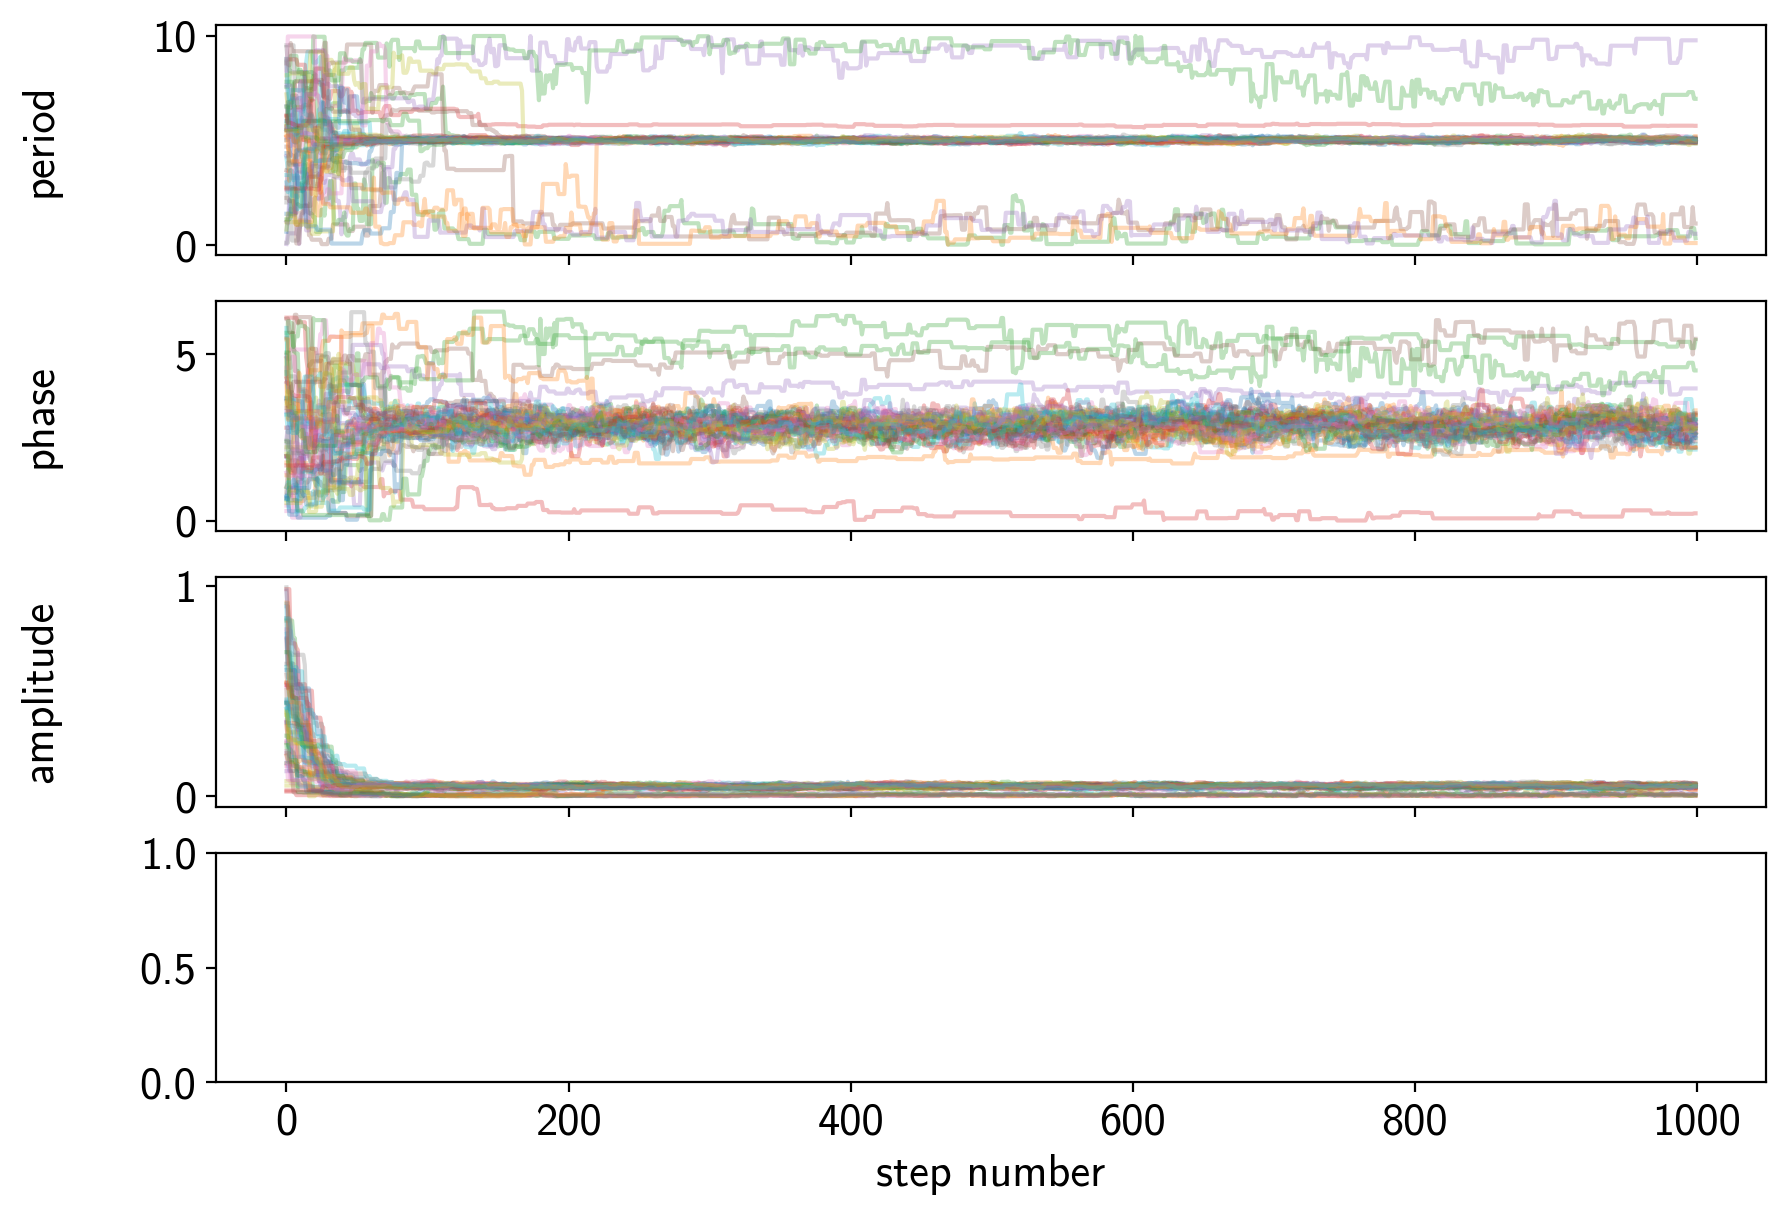

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = mysamples.chain
labels = ["period", "phase", "amplitude"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [18]:
%% time

median = np.median(samples, axis=(0, 1))
std = 1.4826 * np.median(np.abs(samples - median), axis=(0, 1))
initial_pos = [median + std * np.random.randn(3) for k in range(nwalkers)]
mysamples.reset()
mysamples.run_mcmc(initial_pos, 2000);
mysamples.chain.shape

ERROR:root:Cell magic `%%` not found.


CPU times: user 499 ms, sys: 83.1 ms, total: 583 ms
Wall time: 584 ms


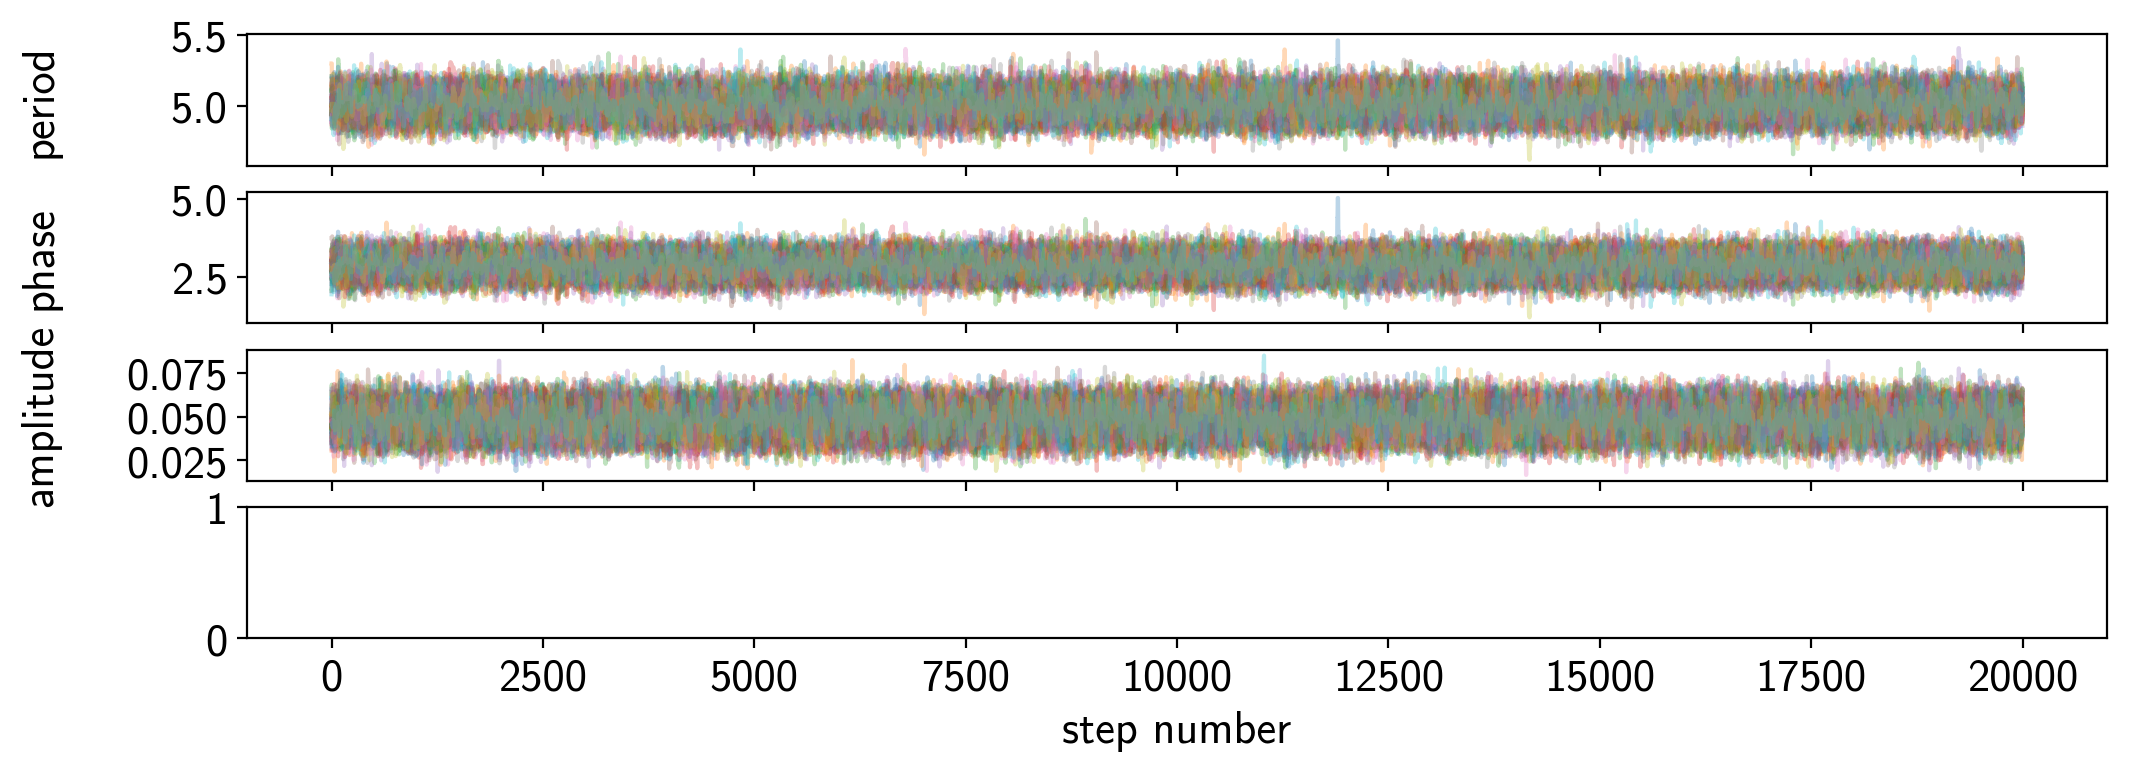

In [19]:
%%time 

fig, axes = plt.subplots(4, sharex=True)
samples = mysamples.chain
labels = ["period", "phase", "amplitude"]
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(samples[k, :, i], alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

In [20]:
mysamples.acor
number_of_eff_steps = 100000 / mysamples.acor
print(number_of_eff_steps)

[ 3666.49428395  3383.53094989  4689.78076145]


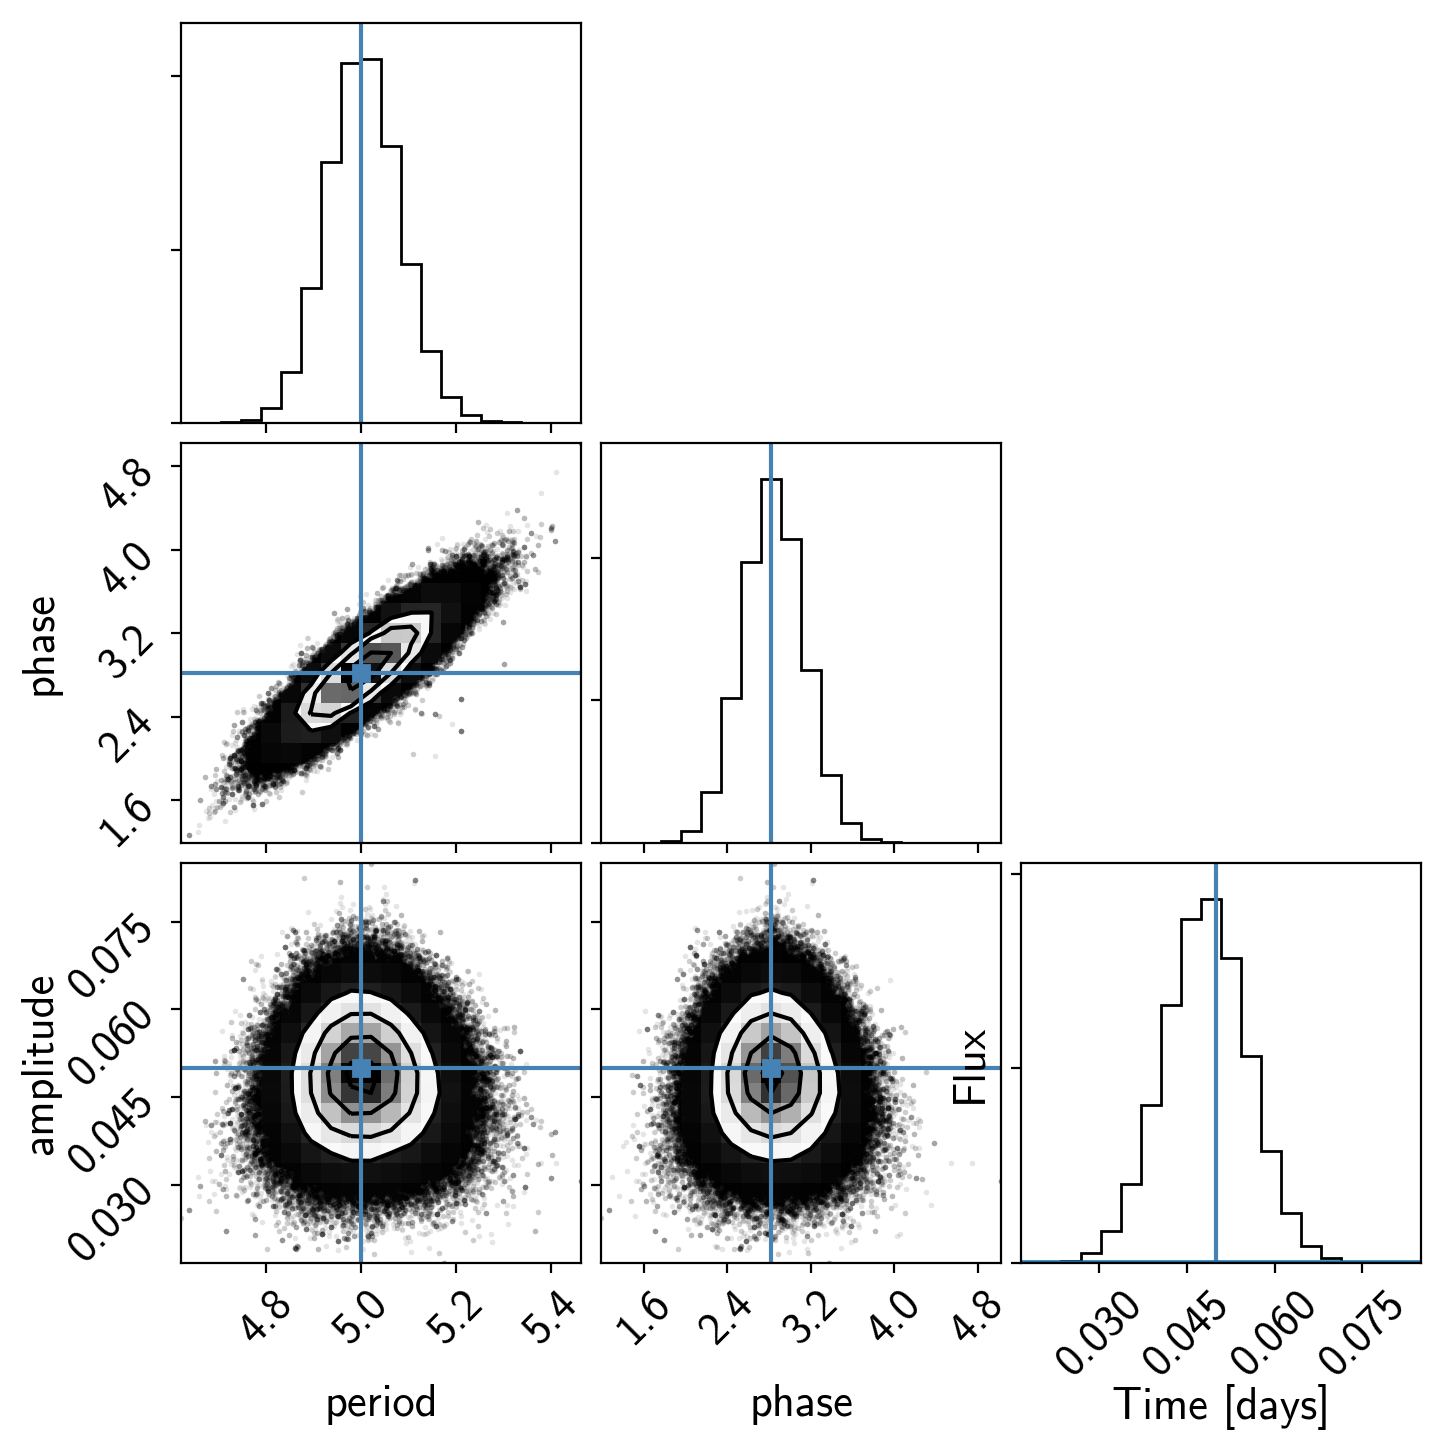

In [22]:
true_values = [truths[label] for label in labels]
flat_samples = samples.reshape(-1, 3)
fig = corner.corner(flat_samples, labels=labels, truths=true_values)
plt.plot(time, flux, 'k.', ms=2, alpha=0.3)
for i in range(50):
    idx = np.random.randint(len(flat_samples))
    plt.plot(time, model(*flat_samples[idx]), "C0", alpha=0.3)
plt.xlabel("Time [days]")
plt.ylabel("Flux");

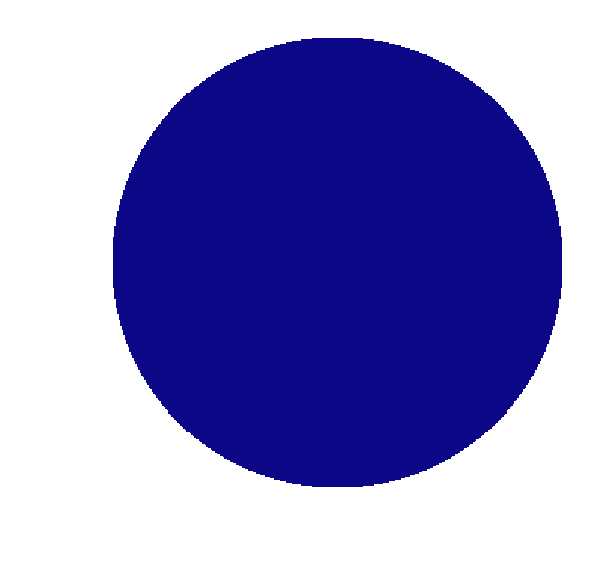

In [23]:
#Trying to map with exoplanet2.fits
map = starry.Map(lmax=5)
map.y
map.show()

In [34]:
map(x=0, y=0)
np.pi * 2.0 ** 3 * map(x=0, y=0)
map.flux()

0.9999999999999997

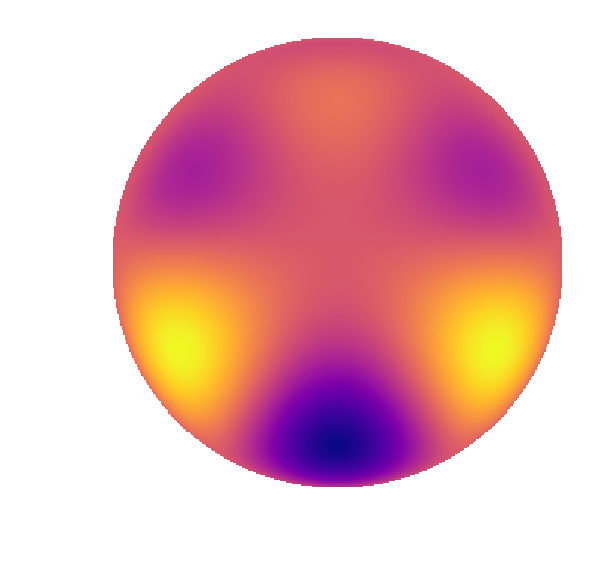

/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: outfile must be *.htm or *.html

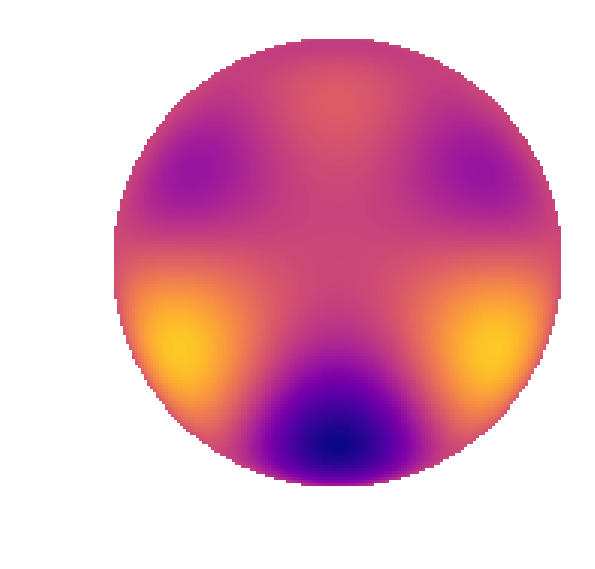

In [42]:
map[3, 2] = 7
map[-6, 4] = -3
map.show()
map.animate()

In [46]:
data = "exoplanet2.fits"